## 毫米波雷达运动目标解析项目实践
代码功能：

根据设置的雷达和目标参数，生成模拟数据。

采用传统信号处理的方法解析单个或多个运动目标的距离，速度和角度。


项目说明：

调整雷达和目标的参数，可视化雷达原始的信号（信号通过模拟方式生成，这部分不需要掌握）

In [200]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math

### 雷达参数

In [201]:
# 雷达参数
B = 0.5 * 1e9 # 带宽 (GHz)
Tc = 40 * 1e-6 # Chirp时间 (s)
S = B / Tc # 频率变化率 (GHz/s)
fc = 79 * 1e9 # 起始频率 (GHz)
c = 3 * 1e8 # 光速 (m/s)
wl = c / fc # 波长 (m)
l =  wl / 2 # 天线间距 (m) 
chirp_num = 128 # 每帧Chirp数量
sample_num = 1024 # 每个Chirp的采样数量
antenna_num = 8 # 天线数量
angle_num = 180 # 角度数量
Fs = sample_num / Tc # 数模转换频率

### 1：计算距离和速度的分辨率和测量范围，以及角度的测量范围
说明
1. 距离FFT的结果具有对称性，因此只能采用一半的频谱。可以将FFT后的结果进行可视化，加以验证。
2. 速度的值是有正负的（符号表示速度方向，0表示相对雷达静止）
2. 角度的值是有正负的（符号表示左右，0度是雷达天线轴(Boresight)的方向）

In [202]:
#速度分辨率
delta_v = wl/(2*Tc*chirp_num)
print("速度分辨率:{}m/s".format(delta_v))
#距离分辨率
delta_r = c/(2*B)
print("距离分辨率:{}m".format(delta_r))
#速度测量范围
v_max = wl/(4*Tc)
print("速度测量范围:[-{}m/s,{}m/s]".format(v_max,v_max))
#距离测量范围
r_max = sample_num * c / (4*B)  #单位纳米
r_max1 = B*c/(2*S)
L = min(r_max,r_max1)
print("距离测量范围:{}m".format(L))
#角度测量范围
theta_max = math.asin(wl/(2*l))
print("角度测量范围:[-{},{}]".format(theta_max,theta_max))


速度分辨率:0.3708465189873418m/s
距离分辨率:0.3m
速度测量范围:[-23.734177215189874m/s,23.734177215189874m/s]
距离测量范围:153.6m
角度测量范围:[-1.5707963267948966,1.5707963267948966]


### FMCW雷达信号模拟（单目标）

In [203]:
# 设置目标信息
R = 50 # range of target (m)
D = 10 # doppler of target (m/s)
A = 20 # angle of target (degree)
print("目标距离: {:f}米".format(R))
print("目标速度: {:f}米/秒".format(D))
print("目标角度: {:f}度".format(A))

# 生成模拟的雷达信号 (单目标)
const_a = l/wl * np.sin(np.deg2rad(A))
print(const_a)
const_d = 2*fc/c*Tc * D
print(const_d)
const_r = 2*S/c/sample_num*Tc * R
print(const_r)
range_a = np.arange(0, antenna_num) # antenna_num = 8 天线个数
range_d = np.arange(0, chirp_num)   # chirp_num = 128一个周期的信号发射次数
range_r = np.arange(0, sample_num)  # sample_num=1024 单个IF信号的采样频率
grid_adr = np.stack(np.meshgrid(range_a, range_d, range_r, indexing='ij'), axis=-1) # 返回立体格子每个格子的坐标位置，
                                                                                    # 这里表示每个坐标点处代表的【M,N,K】信息
signal = grid_adr * np.array([const_a, const_d, const_r])
signal = np.cos(2*np.pi * np.sum(signal, axis=-1))
print(signal.shape)

目标距离: 50.000000米
目标速度: 10.000000米/秒
目标角度: 20.000000度
0.17101007166283436
0.21066666666666664
0.16276041666666669
(8, 128, 1024)


### FMCW雷达信号处理

(8, 128, 512)
(8, 128, 512)
(180, 128, 512)
(128, 512)


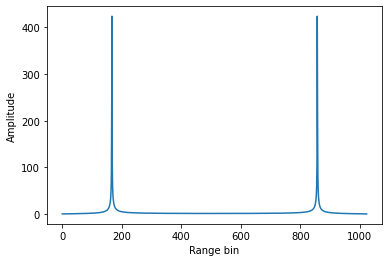

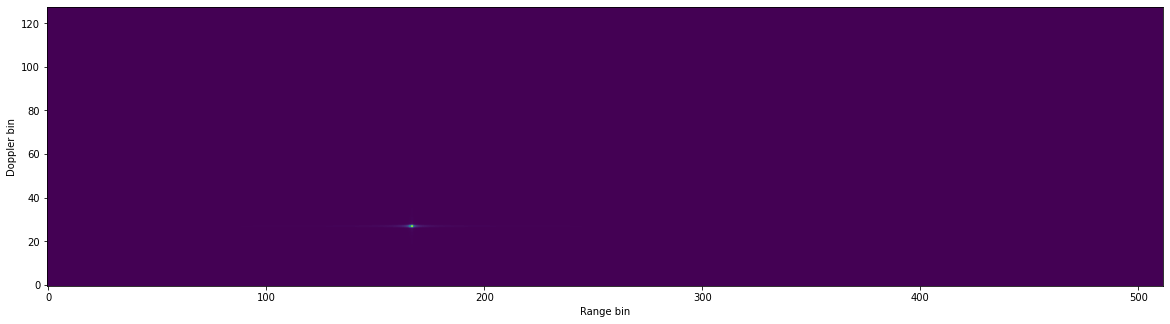

In [204]:
# 距离FFT
s_r = np.fft.fft(signal, axis=2)
plt.plot(np.abs(s_r[0, 0, :])) # 验证距离FFT结果的对称性
plt.xlabel('Range bin')
plt.ylabel('Amplitude')
s_r = s_r[:, :, 0:int(sample_num/2)] # 考虑到对实数做FFT后频谱的对称性，只采用前半部分信号
print(s_r.shape)
# 速度FFT
s_rd = np.fft.fft(s_r, axis=1) 
print(s_rd.shape)
# 角度FFT
s_rda = np.fft.fft(s_rd, axis=0, n=angle_num)#置输出的角度Bin的个数
print(s_rda.shape)
# 可视化 Range-Doppler map
rd_map = np.mean(np.abs(s_rda),axis=0)
print(rd_map.shape)
plt.figure(figsize=(20,10))
plt.imshow(rd_map,origin='lower')
plt.xlabel('Range bin')
plt.ylabel('Doppler bin')
plt.show()

### 估计目标的距离，速度

In [205]:
# 在Range-Doppler map上找到range和doppler的峰值
[d_peak, r_peak] = np.unravel_index(np.argmax(rd_map, axis=None), rd_map.shape) 

# 估计目标的距离
Delta_f = r_peak / sample_num * Fs # 计算range峰值对应的频率差（range bin转换为频率）
R_est = Delta_f * c / (2*S) 
print("目标距离: {:f}米".format(R_est))

# 估计目标的速度
if d_peak >= chirp_num/2: # 频谱的后半段对应负的速度
    d_peak -= chirp_num
Delta_phi = d_peak / chirp_num * 2*np.pi # 计算doppler峰值对应的相位差（doppler bin转换为相位）
D_est = Delta_phi * wl / (4*np.pi * Tc)
print("目标速度: {:f}米/秒".format(D_est))

目标距离: 50.100000米
目标速度: 10.012856米/秒


### 2：估计目标的角度
说明
1. 在Range和Doppler的峰值位置，找到Angle频谱的峰值位置
2. 频谱的后半段对应负的角度（参考速度的处理）
3. 越靠近90度时，角度估计越不准确

In [206]:
a_peak = np.argmax(abs(s_rda[:,d_peak,r_peak]),axis=0)
if a_peak>=angle_num/2:#1024为角度bin个数
    a_peak -= angle_num
Delta_fai = a_peak/angle_num*2*np.pi
est_A =  np.degrees(np.arcsin(wl*Delta_fai)/(2*np.pi*l))
print("目标角度估计为.{}".format(est_A))

目标角度估计为.19.735268485240717


### FMCW雷达信号模拟（多目标）
### 3：估计多个目标的距离，速度和角度
说明
1. 生成多目标的模拟信号 
2. 3次FFT处理，可视化Range-Doppler map
2. 在Range-Doppler map上找到多个目标对应的峰值（可以调用库函数）
3. 设定一个合适的噪声阈值，过滤掉假目标

In [207]:
# 设置目标信息
R = [20, 25] # range of targets (m)
D = [10, 20] # doppler of targets (m/s)
A = [20, 30] # angle of targets (degree)
target_num = len(R)
for i in range(target_num):
    print("目标{:d}距离: {:f}米".format(i+1, R[i]))
    print("目标{:d}速度: {:f}米/秒".format(i+1, D[i]))
    print("目标{:d}角度: {:f}度".format(i+1, A[i]))
    print("\n")

# 生成模拟的雷达信号 (多目标)
const_a= l/wl
const_d = 2*fc/c*Tc
const_r = 2*S/c/sample_num*Tc
range_a = np.arange(0, antenna_num)
range_d = np.arange(0, chirp_num)
range_r = np.arange(0, sample_num)
grid_adr = np.stack(np.meshgrid(range_a, range_d, range_r, indexing='ij'), axis=-1)
signal = np.zeros([antenna_num, chirp_num, sample_num], dtype=np.float)
for i in range(target_num):
    single_target = grid_adr * np.array([const_a*np.sin(np.deg2rad(A[i])), const_d*D[i], const_r*R[i]])
    single_target = np.cos(2*np.pi * np.sum(single_target, axis=-1))
    signal += single_target
print(signal.shape)

目标1距离: 20.000000米
目标1速度: 10.000000米/秒
目标1角度: 20.000000度


目标2距离: 25.000000米
目标2速度: 20.000000米/秒
目标2角度: 30.000000度


(8, 128, 1024)


D:\anaconda3.8\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### 3-2      3次FFT处理，可视化Range-Doppler map

(128, 512)


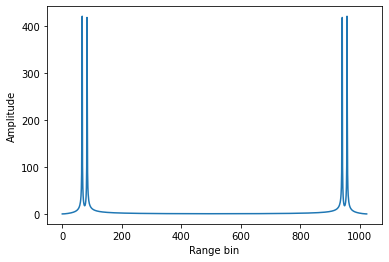

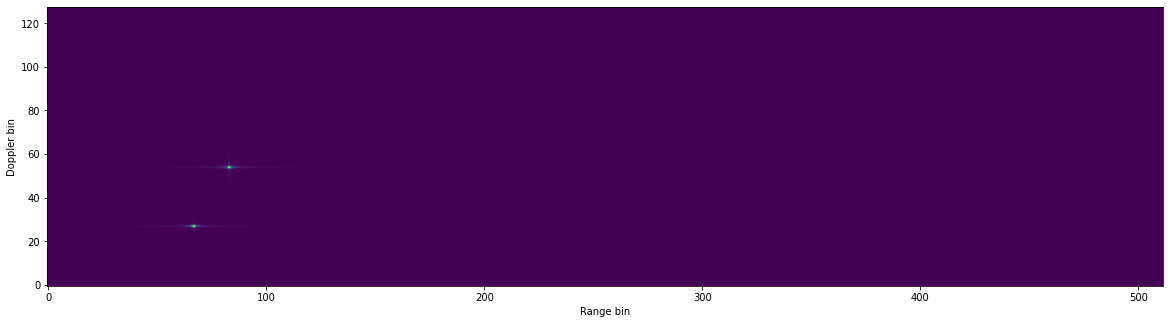

In [208]:
#距离FFT
m_r = np.fft.fft(signal,axis = 2)
plt.plot(np.abs(m_r[0, 0, :])) # 验证距离FFT结果的对称性
plt.xlabel('Range bin')
plt.ylabel('Amplitude')
m_r = m_r[:,:,0:int(sample_num/2)]
#速度FFT
m_rd = np.fft.fft(m_r,axis = 1)
#角度FFT
m_rda = np.fft.fft(m_rd,axis=0,n=angle_num)
# 可视化 Range-Doppler map
mrd_map = np.mean(np.abs(m_rda),axis=0)
print(mrd_map.shape)
plt.figure(figsize=(20,10))
plt.imshow(mrd_map,origin='lower')
plt.xlabel('Range bin')
plt.ylabel('Doppler bin')
plt.show()

### 3-3：在Range-Doppler map上找到多个目标对应的峰值（可以调用库函数）

In [209]:
# 求二维数组的局部峰值
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp

def detect_peaks(nums):

    neighborhood = generate_binary_structure(2,2)

    local_max = maximum_filter(nums, footprint=neighborhood)==nums

    background = (nums==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    detected_peaks = local_max ^ eroded_background
    return detected_peaks

res = np.array(np.nonzero(detect_peaks(mrd_map))).T
# 未过滤前的峰值信息
print(res)

[[ 27  67]
 [ 54  83]
 [ 74   0]
 [ 74  67]
 [ 74  83]
 [ 74 511]
 [101   0]
 [101  67]
 [101  83]
 [101 511]
 [127  67]
 [127  83]]


In [197]:
# 利用峰值来求估计的目标
def DR(m_rda,data):
    
    for i in range(data.shape[0]):
        d_peak = data[i][0]
        r_peak = data[i][1]
        print("预测第{}个目标为:".format(i+1))
        # 估计目标的距离
        Delta_f = r_peak / sample_num * Fs # 计算range峰值对应的频率差（range bin转换为频率）
        R_est = Delta_f * c / (2*S) 
        print("目标距离: {:f}米".format(R_est))

        # 估计目标的速度
        if d_peak >= chirp_num/2: # 频谱的后半段对应负的速度
            d_peak -= chirp_num
        Delta_phi = d_peak / chirp_num * 2*np.pi # 计算doppler峰值对应的相位差（doppler bin转换为相位）
        D_est = Delta_phi * wl / (4*np.pi * Tc)
        print("目标速度: {:f}米/秒".format(D_est))

        a_peak = np.argmax(abs(m_rda[:,d_peak,r_peak]),axis=0)
        if a_peak>=angle_num/2:
            a_peak -= angle_num
        Delta_fai = a_peak/angle_num*2*np.pi
        est_A =  np.degrees(np.arcsin(wl*Delta_fai)/(2*np.pi*l))
        print("目标角度估计为.{}".format(est_A))
        print("\n")
    
print("过滤前多个目标估计为:")
DR(m_rda,res)

过滤前多个目标估计为:
预测第1个目标为:
目标距离: 20.100000米
目标速度: 10.012856米/秒
目标角度估计为.19.735268485240717


预测第2个目标为:
目标距离: 20.100000米
目标速度: 20.025712米/秒
目标角度估计为.28.6480596499073


预测第3个目标为:
目标距离: 0.000000米
目标速度: -20.025712米/秒
目标角度估计为.-28.6480596499073


预测第4个目标为:
目标距离: 20.100000米
目标速度: -20.025712米/秒
目标角度估计为.31.19458819135096


预测第5个目标为:
目标距离: 153.300000米
目标速度: -20.025712米/秒
目标角度估计为.-28.6480596499073


预测第6个目标为:
目标距离: 0.000000米
目标速度: -10.012856米/秒
目标角度估计为.-19.735268485240717


预测第7个目标为:
目标距离: 20.100000米
目标速度: -10.012856米/秒
目标角度估计为.-19.735268485240717


预测第8个目标为:
目标距离: 153.300000米
目标速度: -10.012856米/秒
目标角度估计为.-19.735268485240717


预测第9个目标为:
目标距离: 20.100000米
目标速度: -0.370847米/秒
目标角度估计为.33.10449031394753




### 3-4    设定一个合适的噪声阈值，过滤掉假目标

In [210]:
#对待处理点除去保护单元以外的估计单元元素求均值
def get_mean(raw_data,start,end,neig,alpha):
    # raw_data代表原始的Range-Doppler map
    # start代表求邻居均值的左上角起始位置
    # end代表求邻居均值的右下角起始位置
    # neig代表估计窗口的大小
    # alpha为比例因子
    
    count = 0
    sum = 0
    while neig:
        for j in range(start[1],end[1]):
            sum += raw_data[start[0]][j]
        for i in range(start[0],end[0]):
            sum += raw_data[i][end[1]]
        for j in range(end[1],start[1],-1):
            sum += raw_data[end[0]][j]
        for i in range(end[0],start[0],-1):
            sum += raw_data[i][start[1]]
        neig -= 1
        count =  count+(end[1]-start[1]+1)*4-4
        start[0] += 1
        start[1] += 1
        end[0] -= 1
        end[1] -= 1
    return sum/count*alpha
        
        
    
def filter(raw_data,raw_idx,protect,neig,alpha):
    # raw_data是原始的多目标Range-Doppler map
    # raw_idx是原始map中求出的所有目标峰值,包括噪声点
    # protect代表CFAR算法中待处理单元周围保护单元的长度
    # neig代表CFAR算法中待处理单元除去保护单元以外估计窗口的长度
    # alpha比例因子
    filter_res = []
    C,R = raw_data.shape[0],raw_data.shape[1]
    # 当待处理的目标的估计窗口完全存在的时候
    for i in range(raw_idx.shape[0]):
        min_x = raw_idx[i][0]-protect-neig
        min_y = raw_idx[i][1]-protect-neig
        max_x = raw_idx[i][0]+protect+neig
        max_y = raw_idx[i][1]+protect+neig
        if min_x >=0 and max_x < C and min_y >=0 and max_y < R:
            cur_val = raw_data[raw_idx[i][0]][raw_idx[i][1]]
            neig_val = get_mean(raw_data,[min_x,min_y],[max_x,max_y],neig,alpha)
            if(cur_val > neig_val):
                filter_res.append([raw_idx[i][0],raw_idx[i][1]])
    return filter_res
                
          
filter_res = filter(mrd_map,res,2,2,20)
print("CFAR算法过滤噪声以后得到的峰值:{}".format(filter_res))
filter_res = np.array(filter_res)
print("过滤多个目标估计为:")
DR(m_rda,filter_res)

CFAR算法过滤噪声以后得到的峰值:[[27, 67], [54, 83]]
过滤多个目标估计为:
预测第1个目标为:
目标距离: 20.100000米
目标速度: 10.012856米/秒
目标角度估计为.19.735268485240717


预测第2个目标为:
目标距离: 24.900000米
目标速度: 20.025712米/秒
目标角度估计为.28.6480596499073




### 4：调整雷达参数，区分距离或速度相近的目标
任务1：区分距离为20.0米和20.2米的目标（速度和角度随意）

任务2：区分速度为10.2米/秒和10.4米/秒的目标（距离和角度随意）

说明
1. 按照作业3中的流程生成多个目标的模拟数据，并解析它们的距离和速度。
2. 调整雷达参数，使得任务1中的目标在距离上可以区分
3. 调整雷达参数，使得任务2中的目标在速度上可以区分。

In [231]:
# 设置目标信息
B = 0.5*1e9
S = B / Tc
chirp_num = 256
R = [20, 25] # range of targets (m)
D = [10.2, 10.4] # doppler of targets (m/s)
A = [20, 30] # angle of targets (degree)
target_num = len(R)
for i in range(target_num):
    print("目标{:d}距离: {:f}米".format(i+1, R[i]))
    print("目标{:d}速度: {:f}米/秒".format(i+1, D[i]))
    print("目标{:d}角度: {:f}度".format(i+1, A[i]))
    print("\n")

# 生成模拟的雷达信号 (多目标)
const_a= l/wl
const_d = 2*fc/c*Tc
const_r = 2*S/c/sample_num*Tc
range_a = np.arange(0, antenna_num)
range_d = np.arange(0, chirp_num)
range_r = np.arange(0, sample_num)
grid_adr = np.stack(np.meshgrid(range_a, range_d, range_r, indexing='ij'), axis=-1)
signal = np.zeros([antenna_num, chirp_num, sample_num], dtype=np.float)
for i in range(target_num):
    single_target = grid_adr * np.array([const_a*np.sin(np.deg2rad(A[i])), const_d*D[i], const_r*R[i]])
    single_target = np.cos(2*np.pi * np.sum(single_target, axis=-1))
    signal += single_target
print(signal.shape)

目标1距离: 20.000000米
目标1速度: 10.200000米/秒
目标1角度: 20.000000度


目标2距离: 25.000000米
目标2速度: 10.400000米/秒
目标2角度: 30.000000度




D:\anaconda3.8\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(8, 256, 1024)


(256, 512)


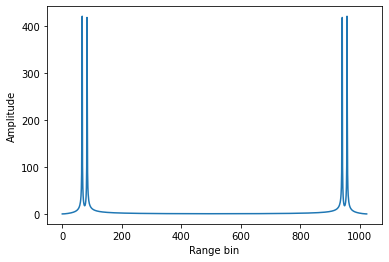

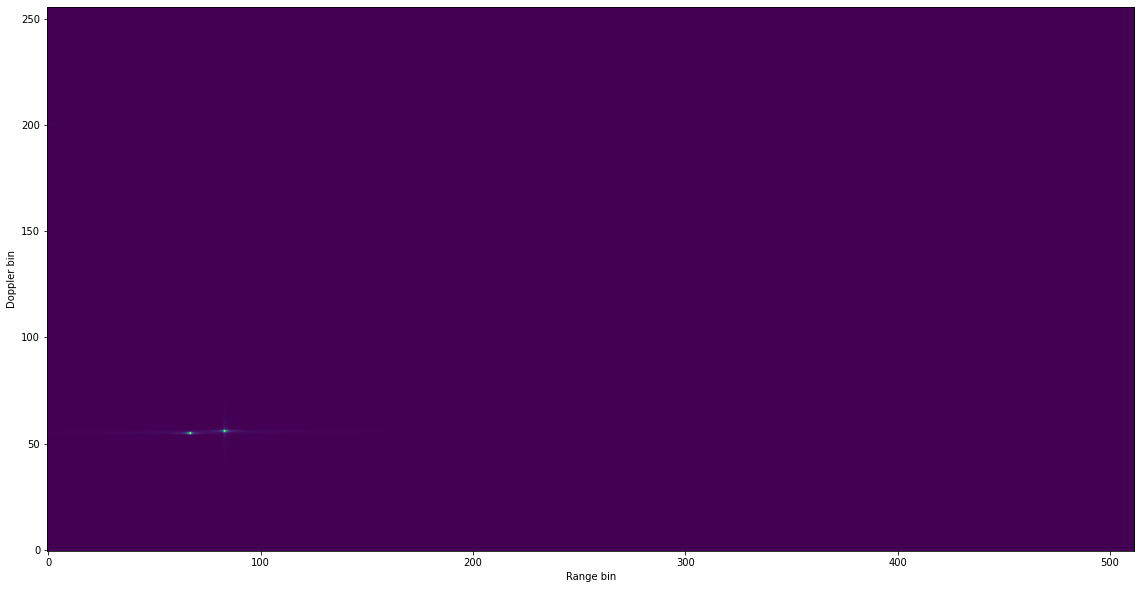

In [232]:
#距离FFT
m_r = np.fft.fft(signal,axis = 2)
plt.plot(np.abs(m_r[0, 0, :])) # 验证距离FFT结果的对称性
plt.xlabel('Range bin')
plt.ylabel('Amplitude')
m_r = m_r[:,:,0:int(sample_num/2)]
#速度FFT
m_rd = np.fft.fft(m_r,axis = 1)
#角度FFT
m_rda = np.fft.fft(m_rd,axis=0,n=angle_num)
# 可视化 Range-Doppler map
mrd_map = np.mean(np.abs(m_rda),axis=0)
print(mrd_map.shape)
plt.figure(figsize=(20,10))
plt.imshow(mrd_map,origin='lower')
plt.xlabel('Range bin')
plt.ylabel('Doppler bin')
plt.show()

In [234]:
res = np.array(np.nonzero(detect_peaks(mrd_map))).T
filter_res = filter(mrd_map,res,2,2,20)
print("CFAR算法过滤噪声以后得到的峰值:{}".format(filter_res))
filter_res = np.array(filter_res)
print("过滤多个目标估计为:")
DR(m_rda,filter_res)

CFAR算法过滤噪声以后得到的峰值:[[55, 67], [56, 83]]
过滤多个目标估计为:
预测第1个目标为:
目标距离: 20.100000米
目标速度: 10.198279米/秒
目标角度估计为.19.735268485240717


预测第2个目标为:
目标距离: 24.900000米
目标速度: 10.383703米/秒
目标角度估计为.28.6480596499073


